In [15]:
# check versions and devices
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
print("python version: ", sys.version)
# print("tf version: ", tf.__version__)
# print("devices: ", tf.config.list_physical_devices())

python version:  3.9.13 (main, Oct 13 2022, 16:12:30) 
[Clang 12.0.0 ]


In [16]:
# create train and validation datasets
batch_size = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/images/",
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=batch_size,
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/images/",
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=batch_size,
    shuffle=True
)

train_ds.class_names

Found 16041 files belonging to 2 classes.
Using 12833 files for training.
Found 16041 files belonging to 2 classes.
Using 3208 files for validation.


['car', 'not_car']

In [17]:
# configure performance
autotune = tf.data.AUTOTUNE

def rsize(image, label):
    image = tf.image.resize(image, (224, 224))
    return image, label

train_ds = train_ds.map(rsize, num_parallel_calls=autotune)
val_ds = val_ds.map(rsize, num_parallel_calls=autotune)

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)

In [18]:
# model -> fine tuning pre-trained model imported from CNN-1.6 by Mario Peng Lee
model = tf.keras.Sequential([
  # input layer: dynamic input size
  tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
  # rescaling to 0-1
  tf.keras.layers.Rescaling(1./255),
  # hidden layers: conv2D + maxpooling (note: batchnorm not used as destroys validation accuracy)
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  # flatten and dense layers
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  # output layer
  tf.keras.layers.Dense(2)
])
model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 32)       

In [19]:
# compile model
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [20]:
# train
import tensorflow as tf
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
101/101 [==============================] - 76s 726ms/step - loss: 0.4184 - accuracy: 0.8108 - val_loss: 0.2274 - val_accuracy: 0.9165
Epoch 2/3
101/101 [==============================] - 70s 692ms/step - loss: 0.2237 - accuracy: 0.9155 - val_loss: 0.1791 - val_accuracy: 0.9373
Epoch 3/3
101/101 [==============================] - 70s 693ms/step - loss: 0.1835 - accuracy: 0.9306 - val_loss: 0.1970 - val_accuracy: 0.9230


In [21]:
# save model
import pandas as pd

model.save('model.h5')
hist_df = pd.DataFrame(history.history)
with open("hist.json", "w") as f:
    hist_df.to_json(f)


In [22]:
# load
from tensorflow.keras.models import load_model
import pandas as pd
from tensorflow_hub import KerasLayer
import pandas as pd

model = load_model('model.h5')
model_hist = pd.read_json("hist.json")

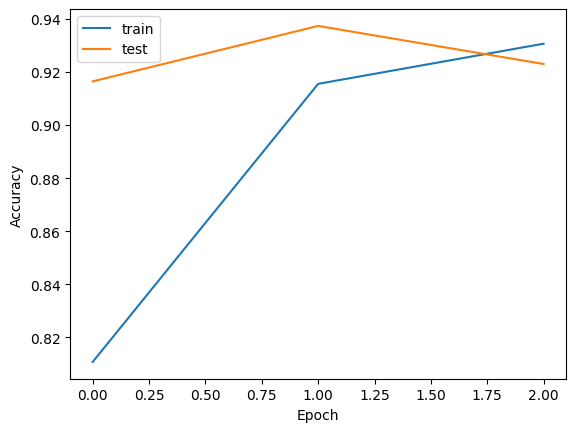

In [23]:
# plot accuracy and val_accuracy
import matplotlib.pyplot as plt
plt.plot(model_hist['accuracy'], label='train')
plt.plot(model_hist['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

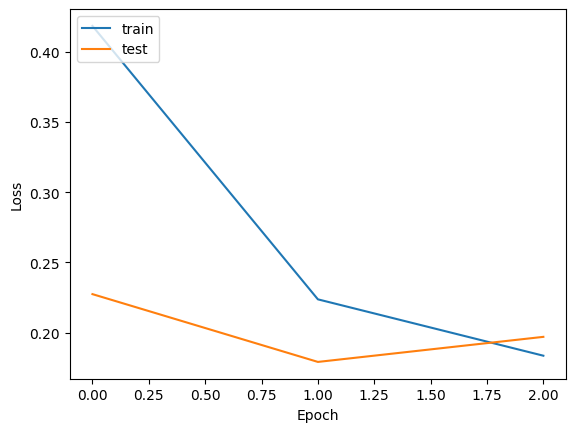

In [24]:
# plot loss and val_loss
plt.plot(model_hist['loss'], label='train')
plt.plot(model_hist['val_loss'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()